In [1]:
import os,glob
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,  GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback,EarlyStopping
from sklearn import metrics
#for ResNet50
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import classification_report,confusion_matrix
#for Xception
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions
from keras.applications.xception import Xception, preprocess_input
#MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Sequential

In [3]:
#get file path of training data 
file_path='MelanomaImages'
#get classes from folder names for benign and malignant
name_class=os.listdir(file_path)
name_class

['benign', 'malignant']

In [4]:
#get and store filepaths of all images
filepaths=list(glob.glob(file_path+'/**/*.*'))
#store the labels according to folder
labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [5]:
#store data as series
filepath= pd.Series(filepaths, name='Filepath').astype(str)
labels=pd.Series(labels, name='Label')
data=pd.concat([filepath, labels],axis=1)
data=data.sample(frac=1).reset_index(drop=True)
data.head(5)

,Filepath,Label
0,MelanomaImages\benign\ISIC_5891587.JPG,benign
1,MelanomaImages\malignant\ISIC_5634599.JPG,malignant
2,MelanomaImages\malignant\ISIC_0065969.JPG,malignant
3,MelanomaImages\malignant\ISIC_0504165.JPG,malignant
4,MelanomaImages\benign\ISIC_3182500.JPG,benign


(array([0, 1]), [Text(0, 0, 'benign'), Text(1, 0, 'malignant')])

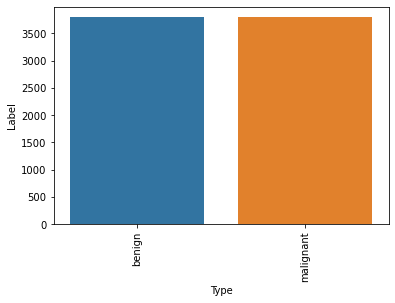

In [6]:
#check count of each class
counts=data.Label.value_counts()
sb.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90)

In [7]:
#train test split for validation with 0.25 
train, test= train_test_split(data, test_size=0.25, random_state=53)

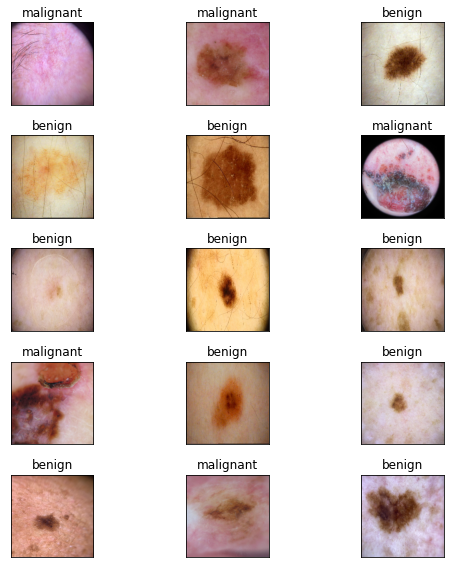

In [147]:
#some example data
fig, axes= plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    img=plt.imread(data.Filepath[i])
    ax.imshow(cv2.resize(img, (224,224)))
    ax.set_title(data.Label[i])
    plt.tight_layout()
plt.show()

In [174]:
#apply preprocessing: normalizing, reshaping, augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input
)

In [175]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5700 validated image filenames belonging to 2 classes.
Found 1900 validated image filenames belonging to 2 classes.
Found 1900 validated image filenames belonging to 2 classes.


In [59]:
pretrained_model = Xception(weights='imagenet', 
                      include_top=False,
                     input_shape=(224,224,3)
                     )
pretrained_model.trainable = False

#add a global spatial average pooling layer
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(200,activation='elu')(x)
x = Dropout(0.4)(x)
x = Dense(170,activation='elu')(x)
outputs = Dense(2,activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

In [60]:
history=model.fit(train_gen, 
          validation_data=valid_gen,
          epochs=10)

Epoch 1/10
179/179 [==============================] - 1917s 11s/step - loss: 0.4286 - accuracy: 0.8102 - val_loss: 4.9464 - val_accuracy: 0.4932
Epoch 2/10
179/179 [==============================] - 1861s 10s/step - loss: 0.3721 - accuracy: 0.8388 - val_loss: 1.4769 - val_accuracy: 0.5068
Epoch 3/10
179/179 [==============================] - 1880s 11s/step - loss: 0.3418 - accuracy: 0.8530 - val_loss: 0.7261 - val_accuracy: 0.7084
Epoch 4/10
179/179 [==============================] - 1896s 11s/step - loss: 0.3240 - accuracy: 0.8558 - val_loss: 0.5298 - val_accuracy: 0.7321
Epoch 5/10
179/179 [==============================] - 1965s 11s/step - loss: 0.3191 - accuracy: 0.8663 - val_loss: 0.3910 - val_accuracy: 0.8089
Epoch 6/10
179/179 [==============================] - 1889s 11s/step - loss: 0.2985 - accuracy: 0.8733 - val_loss: 0.4199 - val_accuracy: 0.8289
Epoch 7/10
179/179 [==============================] - 1808s 10s/step - loss: 0.2958 - accuracy: 0.8721 - val_loss: 0.5583 - val_ac

In [61]:
model.save("model_xception.h5")

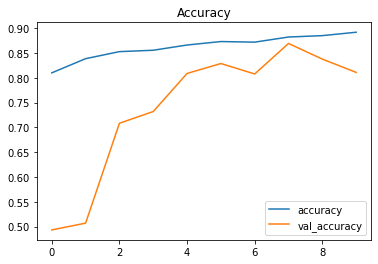

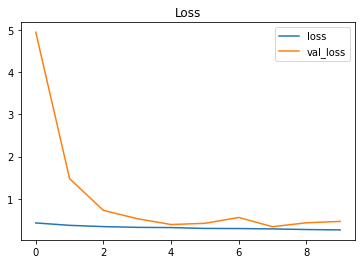

In [62]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [76]:
results = model.evaluate(test_gen, verbose=0)

print("\tTest Loss: {:5f}".format(results[0]))
print("test Accuracy: {:2f}%".format(results[1]*100))

	Test Loss: 0.480279
test Accuracy: 80.421054%


In [65]:
pred= model.predict(test_gen)
pred=np.argmax(pred,axis=1)

labels=(train_gen.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

60/60 [==============================] - 183s 3s/step


In [66]:
y_test=list(test.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      benign       0.72      0.99      0.83       963
   malignant       0.98      0.61      0.75       937

    accuracy                           0.80      1900
   macro avg       0.85      0.80      0.79      1900
weighted avg       0.85      0.80      0.79      1900



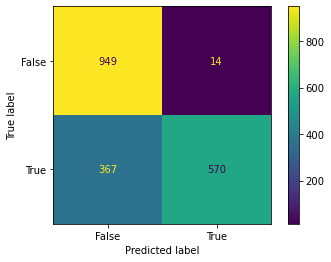

In [74]:
#confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
#apply preprocessing: normalizing, reshaping, augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,horizontal_flip=True,
    preprocessing_function=preprocess_input
)
test_datagen = ImageDataGenerator(
    rescale=1./255,
        preprocessing_function=preprocess_input
)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

In [203]:
pretrained_model.trainable = False
pretrained_model = Xception(weights='imagenet', 
                      include_top=False,
                     input_shape=(224,224,3)
                     )
#add a global spatial average pooling layer
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(200,activation='elu')(x)
x = Dropout(0.4)(x)
x = Dense(170,activation='elu')(x)
outputs = Dense(2,activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

In [204]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy']
             )

In [205]:
history = model.fit(train_gen,
                    epochs=10,
                    validation_data=valid_gen)

Epoch 1/10
179/179 [==============================] - 4165s 23s/step - loss: 0.4297 - accuracy: 0.8137 - val_loss: 4.5114 - val_accuracy: 0.4974
Epoch 2/10
179/179 [==============================] - 3673s 20s/step - loss: 0.3588 - accuracy: 0.8470 - val_loss: 4.3262 - val_accuracy: 0.4995
Epoch 3/10
179/179 [==============================] - 1986s 11s/step - loss: 0.3384 - accuracy: 0.8547 - val_loss: 0.5125 - val_accuracy: 0.7284
Epoch 4/10
179/179 [==============================] - 1992s 11s/step - loss: 0.3257 - accuracy: 0.8623 - val_loss: 1.0264 - val_accuracy: 0.6032
Epoch 5/10
179/179 [==============================] - 2219s 12s/step - loss: 0.3161 - accuracy: 0.8672 - val_loss: 0.4012 - val_accuracy: 0.8516
Epoch 6/10
179/179 [==============================] - 2173s 12s/step - loss: 0.3059 - accuracy: 0.8705 - val_loss: 0.4925 - val_accuracy: 0.7647
Epoch 7/10
179/179 [==============================] - 2189s 12s/step - loss: 0.2910 - accuracy: 0.8742 - val_loss: 0.3709 - val_ac

In [206]:
model.save("xception2.h5")

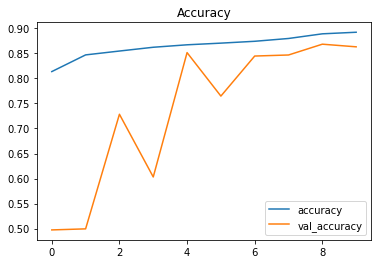

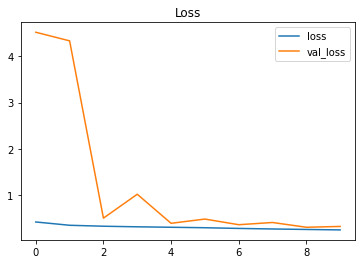

In [207]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()


In [208]:
results= model.evaluate(test_gen, verbose=0)
print("\tTest Loss: {:5f}".format(results[0]))
print("test Accuracy: {:2f}%".format(results[1]*100))

	Test Loss: 0.351806
test Accuracy: 85.842103%


In [210]:
pred= model.predict(test_gen)
pred=np.argmax(pred,axis=1)

labels=(train_gen.class_indices)
labels=dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


60/60 [==============================] - 293s 5s/step


In [217]:
y_test=list(test.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

      benign       0.80      0.96      0.87       955
   malignant       0.95      0.76      0.84       945

    accuracy                           0.86      1900
   macro avg       0.87      0.86      0.86      1900
weighted avg       0.87      0.86      0.86      1900



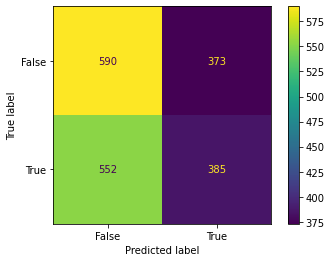

In [213]:
#confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()